# Fundamentals of Machine Learning - Exercise 10
Goal of the excercise is to learn how to use Scikit-learn library for a regression tasks employing various linear regression models and moreover evaluate the performance of the proposed models.

![meme01](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_10_meme_01.jpeg?raw=true)

## 📌 Useful URLs

### Models
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### Preprocessing
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

In [8]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, rmse, mape = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}], index=[0])

## Petrol Consumption Dataset
https://www.kaggle.com/datasets/harinir/petrol-consumption

### 🎯 Our goal is to build a regression model for prediction of petrol consumption in the 48 USA states.

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/master/datasets/petrol_consumption.csv')
df.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


## Is each column numerical?

In [10]:
df.dtypes

Petrol_tax                      float64
Average_income                    int64
Paved_Highways                    int64
Population_Driver_licence(%)    float64
Petrol_Consumption                int64
dtype: object

## Do we have any missing data?

In [11]:
df.isna().sum()

Petrol_tax                      0
Average_income                  0
Paved_Highways                  0
Population_Driver_licence(%)    0
Petrol_Consumption              0
dtype: int64

# 📊 Let's start with a simple EDA

* 🔎 Can you see any relationships among the features from the pairplot?
    * What should we look for?
* 🔎 Do you think that the features are normally distributed?

/tmp/ipykernel_1187196/1111783130.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 1200x1200 with 0 Axes>

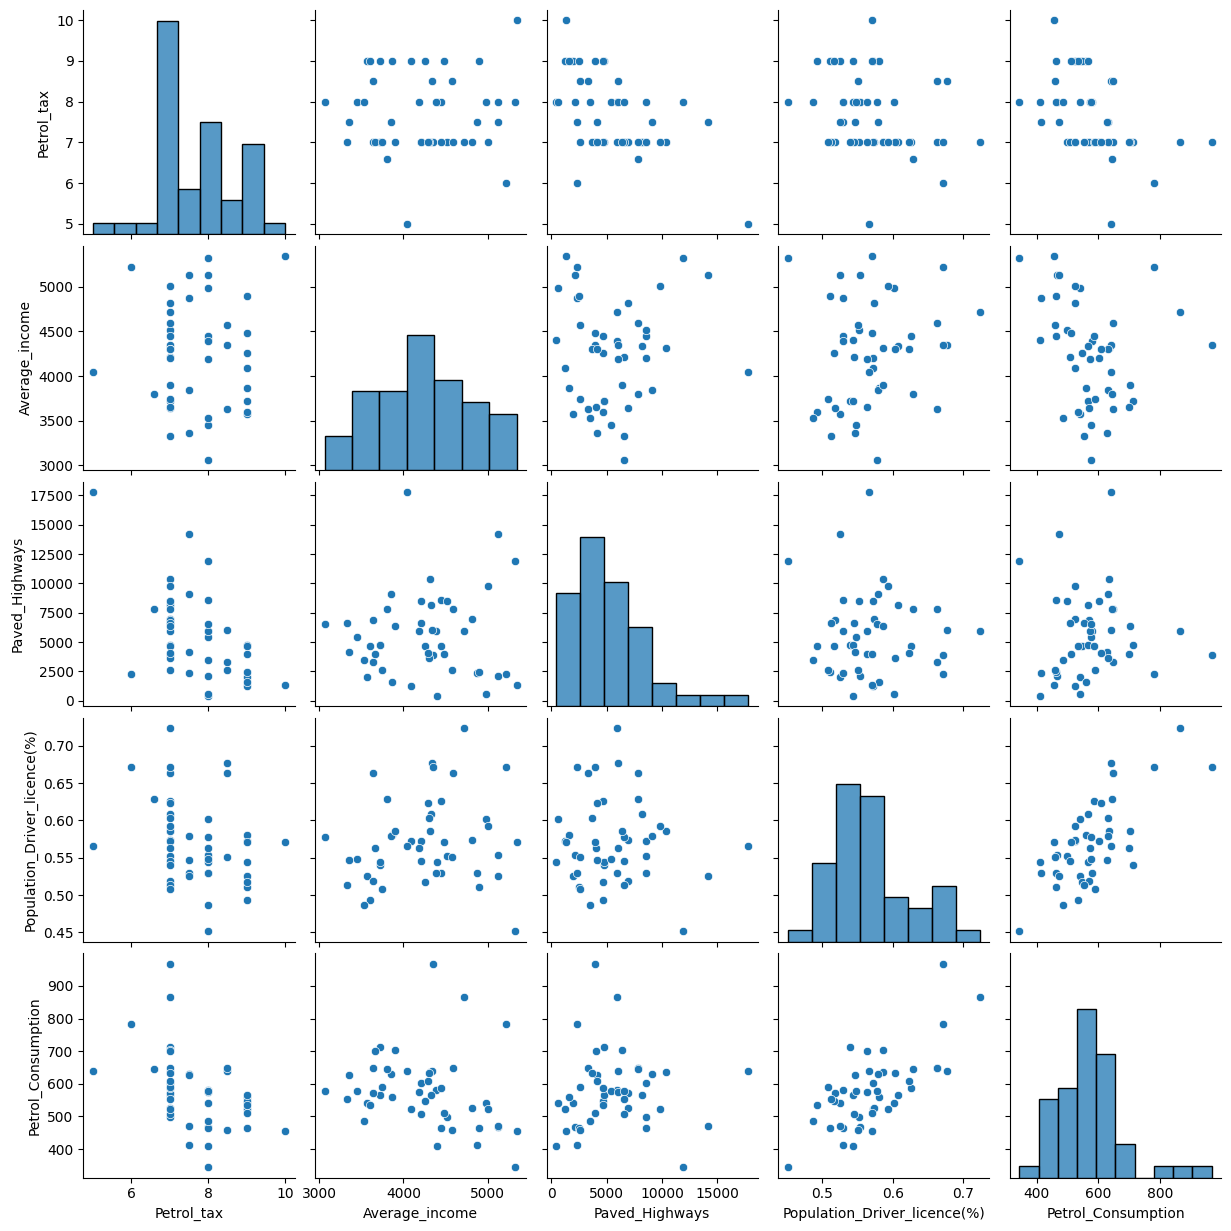

In [12]:
fig = plt.figure(figsize=(12, 12))
sns.pairplot(df)
fig.show()

## Always look for a simple trend-like patters first 🙂
> ## **Trend is your friend** 😀

![meme02](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_10_meme_02.png?raw=true)

## What about the a correlation coefficients?
* 🔎 What row/column is the most important from the heatmap?
    * Why?
* 🔎 Are correlations among **independent variables** good or bad?

<Axes: >

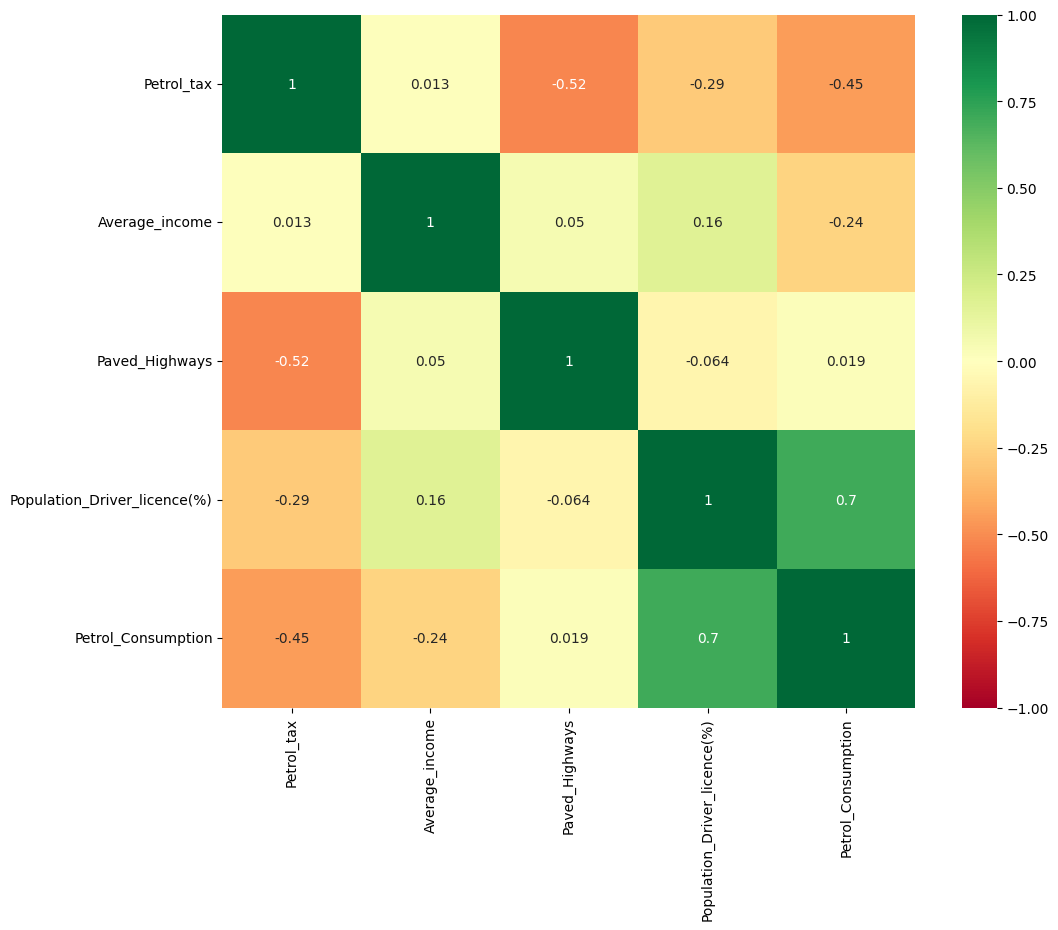

In [13]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn', vmin=-1, vmax=1, annot=True)

## Can you see any outliers in the data?
* What about skewness or variance differences?

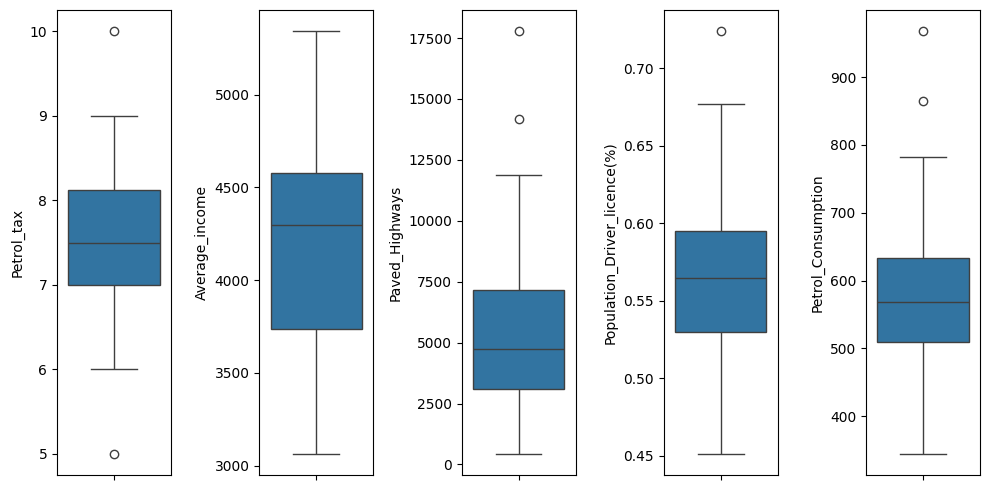

In [14]:
fig, axes = plt.subplots(1, df.shape[1], figsize=(10, 5))

for i, col in enumerate(df.columns):
    ax = axes.flatten()[i]
    sns.boxplot(data=df, y=col, ax=ax)
        
fig.tight_layout()

# 🚀 Let's build our first simple regression models with just 2 variables and compare them
* We will split the data into train/test set
* Then we can build the models and evaluate them

### There are many metrics used for the perormance evaluation
* MAE, RMSE, MAPE, R2, etc.
    * Do you know what these abbr. mean?
* 🔎 **Do we want these metrics to go lower or higher?**
    * Is it the same direction as in classification tasks, e.g. F1-Score, or opposite way around? 
* 💡 You can take a look at these blog posts:
    * [this](https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914)
    * or [this](https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/) for more details

## Create `X` and `y` dataframes

In [55]:
X, y = df.drop('Petrol_Consumption', axis=1), df['Petrol_Consumption']

In [16]:
X.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%)
0,9.0,3571,1976,0.525
1,9.0,4092,1250,0.572
2,9.0,3865,1586,0.580
3,7.5,4870,2351,0.529
4,8.0,4399,431,0.544


In [17]:
y.head()

0    541
1    524
2    561
3    414
4    410
Name: Petrol_Consumption, dtype: int64

## Split the data in ration 80:20

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((38, 4), (10, 4), (38,), (10,))

# ⚡ The 1st model will be the simplest one
* We will choose only one feature for the model - *Population_Driver_licence(%)*
    * 🔎 Why did we chose this specific feature?

In [20]:
s_column = 'Population_Driver_licence(%)'
alg = LinearRegression()
alg.fit(pd.DataFrame(X_train[s_column]), y_train)

LinearRegression()

In [21]:
y_pred = alg.predict(pd.DataFrame(X_test[s_column]))

## 🔎 How would the regression line formula look like?
* 💡 What is a general equation of straight line in 2D? And for nD?

In [22]:
alg.coef_[0]

1409.6506418001031

In [23]:
alg.intercept_

-228.77388463715886

# 💡 Very simple visual check of prediction quality is `y_test vs. y_pred` scatter plot
* What is an ideal result?

<Axes: xlabel='Petrol_Consumption'>

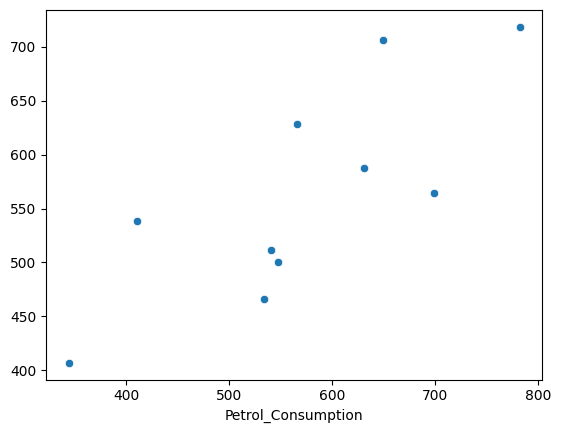

In [24]:
sns.scatterplot(x=y_test, y=y_pred)

# However it is always better to quantify the errors 😊
* 💡MAPE or SMAPE uses percentage values, thus these might be easier to understand to non-expert audience
* 💡MAE, RMSE are in the same units as the predicted variable
    * Always take a look at basic statistical properties (typical value range, variance or use box-plot ) to rationalize the amount of error according to the range or the variable
    * 📌 e.g., MAE = 10 can be low for variable in <1000, 5000> range but very high for variable in <0, 50> range

<Axes: ylabel='Petrol_Consumption'>

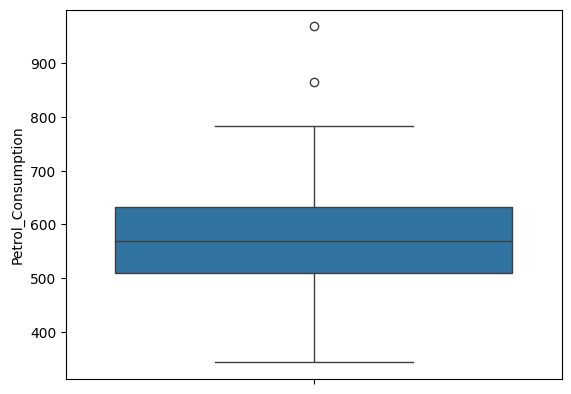

In [25]:
sns.boxplot(y=y)

## So what do you think about the error?
* 💡 Is model completely off or is it roughly right?

In [26]:
compute_metrics_raw(y_true=y_test, y_pred=y_pred)

,MAE,MSE,RMSE,MAPE
0,69.589612,5909.265423,76.871747,13.030434


# ⚡ 2nd model will use just one variable again, however now it will be an uncorrelated one
* 🎯 We want to compare the model with the 1st one

In [27]:
s_column = 'Paved_Highways'
alg = LinearRegression()
alg.fit(pd.DataFrame(X_train[s_column]), y_train)

LinearRegression()

In [28]:
y_pred = alg.predict(pd.DataFrame(X_test[s_column]))

## Let's take a look at the scatterplot of y_test vs. y_pred now

<Axes: xlabel='Petrol_Consumption'>

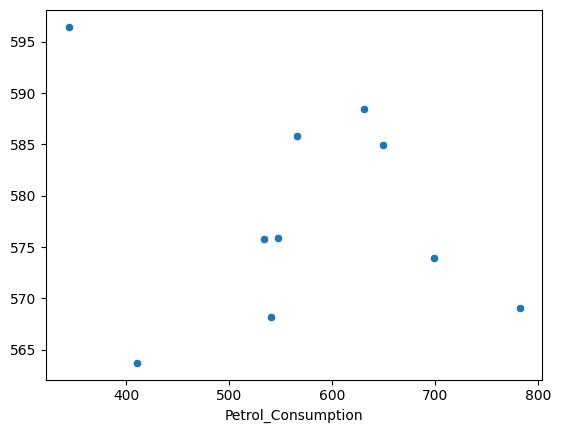

In [29]:
sns.scatterplot(x=y_test, y=y_pred)

## 🔎 Which one of the two models is better and why?

In [30]:
compute_metrics_raw(y_true=y_test, y_pred=y_pred)

,MAE,MSE,RMSE,MAPE
0,96.856205,15798.747857,125.69307,19.426587


# The obvious next step is using more than one feature in the model, so let's get to it! 👊
* The API is the same, we will just include every feature in the model instead of just one

In [31]:
alg = LinearRegression()
alg.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = alg.predict(X_test)

## How would the regression line formula look like now?

In [33]:
alg.coef_

array([-4.02146155e+01, -6.27881489e-02, -3.35821983e-03,  1.42662122e+03])

In [34]:
alg.intercept_

353.4972912944651

## 📊 For MLR we usually also want to take a look at coefficients values so we can "explain" the decisions by the model
* 🔎 Are all the features used?
* 🔎 Is there any feature much more important than other features?

([0, 1, 2, 3],
 [Text(0, 0, 'Petrol_tax'),
  Text(1, 0, 'Average_income'),
  Text(2, 0, 'Paved_Highways'),
  Text(3, 0, 'Population_Driver_licence(%)')])

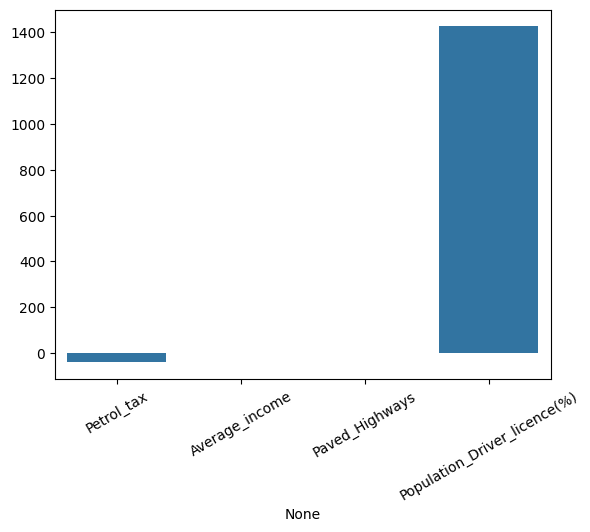

In [35]:
sns.barplot(x=X_train.columns, y=alg.coef_)
plt.xticks(rotation=30)

## 🔎 Is the model better than the 1st one with just one feature?
* How different are the results?

In [36]:
compute_metrics_raw(y_true=y_test, y_pred=y_pred)

,MAE,MSE,RMSE,MAPE
0,64.211372,4960.283075,70.429277,12.194036


## 🔎 Is it wise to have a model with some coefficient of few magnitudes higher values than other coefficients?
* What can go wrong? 
*  What is a **colinearity?** 
    * Why it may become an issue for regression models?

![meme03](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_10_meme_03.jpg?raw=true)

# There are method for dealing with of these issues
* It is called regularization
    * We have two types of it - **L1 (Lasso)** and **L2 (Ridge)**
    * What is the difference between them?
* How is the regularization used?
    * What do we change in the model?
 
* Very nice comparison of both methods is at https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression

# Let's try L1 - Lasso first
* 💡 The most important parameter is the `alpha` value
* Higher alpha means that the regularization will be more strict

In [37]:
alg = Lasso(alpha=3, random_state=13)
alg.fit(X_train, y_train)

Lasso(alpha=3, random_state=13)

In [38]:
y_pred = alg.predict(X_test)

## 💡 Notice the values of coefficients

In [39]:
alg.coef_

array([-5.07274306e+01, -4.45920542e-02, -5.79196797e-03,  2.10886745e+02])

In [40]:
alg.intercept_

1066.6700365032798

([0, 1, 2, 3],
 [Text(0, 0, 'Petrol_tax'),
  Text(1, 0, 'Average_income'),
  Text(2, 0, 'Paved_Highways'),
  Text(3, 0, 'Population_Driver_licence(%)')])

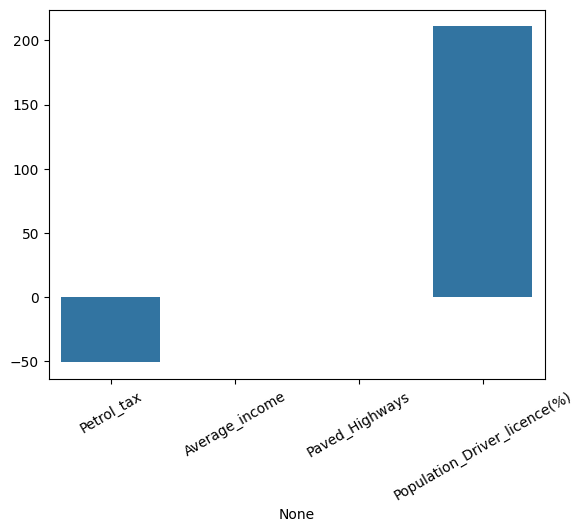

In [41]:
sns.barplot(x=X_train.columns, y=alg.coef_)
plt.xticks(rotation=30)

In [42]:
compute_metrics_raw(y_true=y_test, y_pred=y_pred)

,MAE,MSE,RMSE,MAPE
0,64.087218,6517.545286,80.731315,12.715199


# We can use L2 - Ridge in the same way

In [43]:
alg = Ridge(alpha=1, random_state=13)
alg.fit(X_train, y_train)

Ridge(alpha=1, random_state=13)

In [44]:
y_pred = alg.predict(X_test)

In [45]:
alg.coef_

array([-5.50501422e+01, -4.24193615e-02, -6.57133145e-03,  1.21471042e+02])

In [46]:
alg.intercept_

1146.0866718368409

([0, 1, 2, 3],
 [Text(0, 0, 'Petrol_tax'),
  Text(1, 0, 'Average_income'),
  Text(2, 0, 'Paved_Highways'),
  Text(3, 0, 'Population_Driver_licence(%)')])

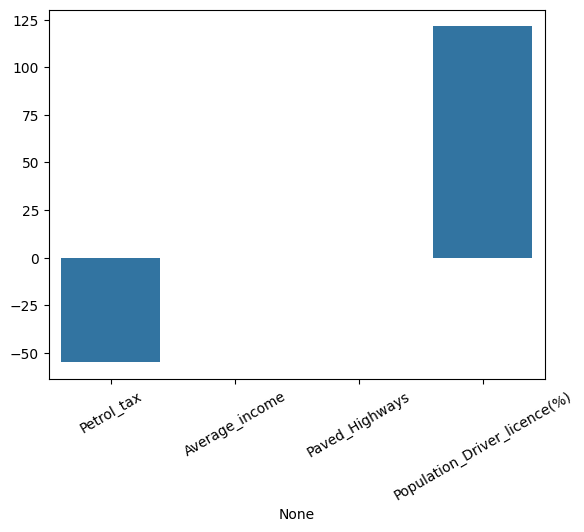

In [47]:
sns.barplot(x=X_train.columns, y=alg.coef_)
plt.xticks(rotation=30)

In [48]:
compute_metrics_raw(y_true=y_test, y_pred=y_pred)

,MAE,MSE,RMSE,MAPE
0,65.337108,6823.203287,82.602683,13.055488


### 🔎 Regardless the used model, what is the difference among the coefficients values with enabled and disabled regularization?

# 💡 There are usually differences among the variables ranges 
* This may bring some difficulties in the coefficient optimization process
* 💡 If the ranges are similar, the optimization process should be a lot easier
    * Why?
* Due to that, we usually use `MinMaxScaler` or `StandardScaler` before we try to fit a linear regression model
    * We are not limited to these two preprocessing methods

# 🚀 We will try to fit the Lasso model again, but this time with scaled features

### 🔎 Why do we fit the scaler only on the training part of the data?

In [49]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

### Try 0.1, 1 and 10 for alpha parameter
* What is different for each run?

In [50]:
def lasso_experiments(X_train_std, y_train, X_test_std, y_pred, alphas=[0.1, 1, 10]):
    results = []
    for alpha in alphas:
        alg = Lasso(alpha=alpha, random_state=13)
        alg.fit(X_train_std, y_train)
        y_pred = alg.predict(X_test_std)
        results.append((alpha, y_pred, alg.coef_))
    return results

In [51]:
alphas = [0.1, 1, 10]
results = lasso_experiments(X_train_std, y_train, X_test_std, y_pred, alphas)

## 🔎 How are the models and results different?

In [52]:
df_results = pd.DataFrame(index = alphas, columns=['MAE', 'MSE', 'RMSE', 'MAPE'])
for i, x in enumerate(results):
    df_results.iloc[i, :] = compute_metrics_raw(y_true=y_test, y_pred=x[1])
df_results

,MAE,MSE,RMSE,MAPE
0.1,64.103846,4943.879923,70.312729,12.159087
1.0,63.12663,4809.468253,69.35033,11.841692
10.0,60.173284,4549.176321,67.447582,10.96381


In [53]:
df_coeffs = pd.DataFrame(index = alphas, columns=X_train.columns)
for i, x in enumerate(results):
    df_coeffs.iloc[i, :] = x[2]
df_coeffs

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%)
0.1,-37.115611,-34.963516,-11.375811,72.416671
1.0,-34.977952,-34.249283,-9.134591,71.714315
10.0,-22.363067,-25.80148,-0.0,63.114001


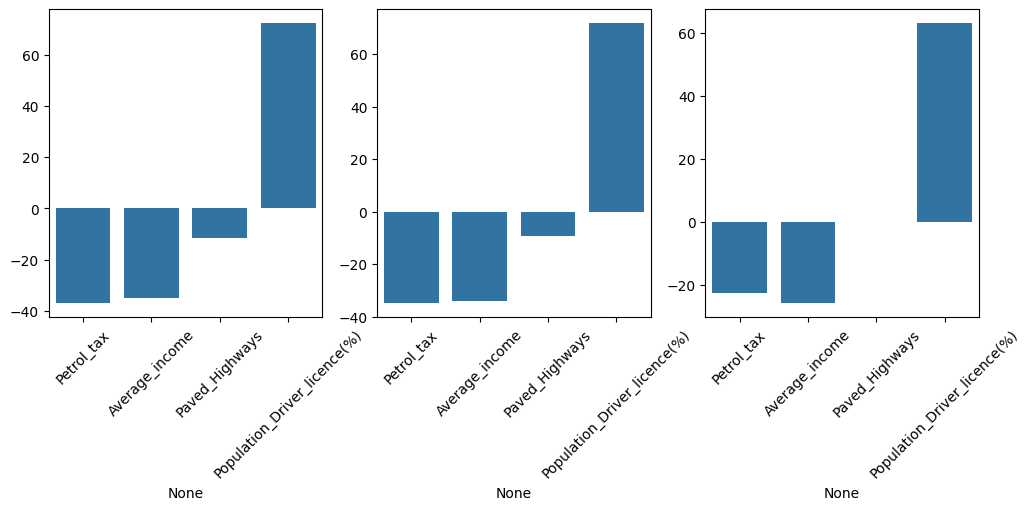

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, x in enumerate(results):
    ax = sns.barplot(x=X_train.columns, y=x[2], ax=axs[i])
    ax.tick_params(axis='x', rotation=45)

# ✅ Task (2p)
* We are obviously not limited to only a linear regression models for the regression tasks
    * Usually there is a regression alternative for most of the classification models in Sk-Learn
* Use [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for the data and compare it to the Linear regression model (**1p**)
    * 💡 Plot the *feature_importances_* if you want to know which features are important for this model
    * More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
* Use [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) model
    * The model combines the L1 and L2 regularization
    * Study how the model works
    * The model has 2 important parameters `alpha` and `l1_ratio`
    * Try to tune them
* Compare the `RandomForestRegressor` and `ElasticNet` models - which of them was more precise? (**1p**)

* Document everything you do in a Markdown cells
    * ❌ Results interpretation figured in real-time during task check is not allowed! ❌